1. Generate training data from noisy process, and generate test data from clean process
2. robustness to outliers - check MSE
3. robustness to noises - check log likelihood of generated data (we can combine outliers here too)

In [219]:
import numpy as np
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt
from data.synthetic import generate_data_function
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
from model.torch_model import PolyRegression
from model.modal_lr import ModalLinearRegression
from train_loop import train_regular, train_adaptive, train_locally_adaptive
from likelihood import Gaussian, Laplace, Adaptive
import torch
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [220]:
def indep_noise(x):
        return npr.normal(0, 0.5, len(x))

def linear_noise(x):
    return npr.normal(0, np.maximum(1,x), len(x))

def exp_noise(x):
    return npr.normal(0, np.exp(1/3*x), len(x))

def output_func(x):
    return 1 / 5 * x ** 2

def complex_noise(x):
    return npr.normal(0,1, len(x))*np.abs(np.abs(x+2)-2)/1.5

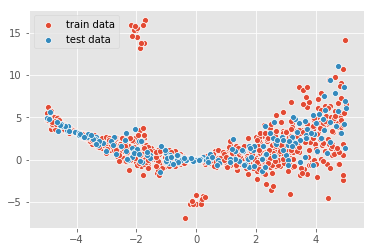

In [221]:
trX, trY, teX, teY = generate_data_function(output_func, complex_noise, 1000, rate=0.03, loc=[-2, 0], yloc=[15, -5])
sns.scatterplot(trX, trY, label='train data')
sns.scatterplot(teX, teY, label='test data')

# sns.lineplot(X_, baseY)

In [222]:
x, y = torch.Tensor(trX), torch.Tensor(trY)
sortedx, idxX = torch.sort(x)
sortedy = y[idxX]
# distribution for evaluation
gaussian = Gaussian()
laplace = Laplace()
adaptive = Adaptive()

In [223]:
lr2 = PolyRegression(2)
fit2 = train_regular(lr2, x, y, gaussian, epoch=1000, learning_rate=1e-2, verbose=False)

100%|██████████| 1000/1000 [00:00<00:00, 1588.11it/s]


In [224]:
# 2-D linear regression + gaussian
y2 = fit2(sortedx).detach().numpy()
eps1 = y2.flatten()-sortedy.numpy().flatten()
gaussian.loglikelihood(eps1)

-1871.0506841159356

In [225]:
# 2-D linear regression + laplace
robust_lr2 = PolyRegression(2)
robust_fit2 = train_regular(robust_lr2, x, y, laplace, epoch=1000, learning_rate=1e-2, verbose=False)

100%|██████████| 1000/1000 [00:00<00:00, 1701.75it/s]


In [226]:
yr2 = fit2(sortedx).detach().numpy()
eps2 = yr2.flatten()-sortedy.numpy().flatten()
laplace.loglikelihood(eps2)

-1589.1818468891008

In [227]:
# 2-D linear regression + adaptive
ada_lr2 = PolyRegression(2)
ada_fit2, alpha, scale = train_adaptive(ada_lr2, x, y, epoch=1000, learning_rate=1e-2, verbose=False)

100%|██████████| 1000/1000 [00:03<00:00, 291.63it/s]


In [228]:
yar2 = ada_fit2(sortedx).view(-1)
eps3 = yar2-sortedy
adaptive.loglikelihood(eps3, alpha, scale)

-1920.8088

In [229]:
# 2-D linear regression + adaptive + regression
ada_lr2 = PolyRegression(2)
alpha_model = PolyRegression(2, init_zeros=True)
scale_model = PolyRegression(2, init_zeros=True)
ada_fit22, alpha_reg, scale_reg = train_locally_adaptive(ada_lr2, alpha_model, scale_model, x, y,
                                                             epoch=1000, learning_rate=1e-2, verbose=False)

100%|██████████| 1000/1000 [00:03<00:00, 287.61it/s]


In [230]:
yarr2 = ada_fit2(sortedx).view(-1)
alphas = torch.exp(alpha_reg(sortedx).view(-1))
scales = torch.exp(scale_reg(sortedx).view(-1))
eps4 = yarr2-sortedy
adaptive.loglikelihood(eps4, alphas, scales)

-1393.4825

# other baseline

In [239]:
# GP
import gpytorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=1),
            ), grid_size=grid_size, num_dims=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
model = ExactGPModel(x, y, likelihood)

In [240]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 50
for i in tqdm(range(training_iter)):
    optimizer.zero_grad()
    output = model(x)
    loss = -mll(output, y)
    loss.backward()
    optimizer.step()

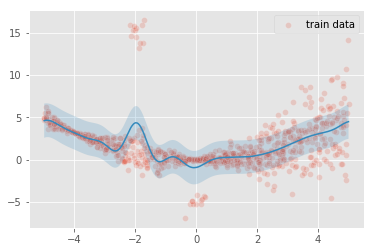

In [241]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(sortedx))
    lower, upper = observed_pred.confidence_region()
    sns.scatterplot(trX, trY, label='train data', alpha=0.2)
    sns.lineplot(sortedx, observed_pred.mean.numpy(), color=palette[1])
    plt.fill_between(sortedx.detach(), lower.numpy(), upper.numpy(), alpha=0.2)

In [242]:
mll(observed_pred, y)*len(y) # the source code devides mll by the size of input -> reconstruct mll 

tensor(-2861.1077, grad_fn=<MulBackward0>)